# <center>Assignment 8 - K-Means and DBSCAN</center>

1. Work through the book (Data Science from Scratch - Chapter 20) - build your own K means cluster function and carry out the moddeling done in the book.


2. Write a brief description of the use cases for K Means and DBSCAN algorithms. Hints on good use cases are in the notes - do further research as needed (e.g. on DBSCAN used in recommendation engines)


3. Thinking about these two algorithms provide a formal definition of clustering


4. Describe with examples of plotting two ways of selecting the value of K for K-Means clustering.


5. Which algorithm is good for large datasets and which one is good for regions of high density?


6. What does 'high density' mean in DBSCAN?


7. Describe with an example how the initialization of K Means can affect the inertia value and the quality of the model.


8. Prepare a model using K Means for the Olivetti data set from scikit learn - this exercise comes from 'Hands on Machine Learning with Scikit-Learn, Keras & TensorFlow' page 275.


The Olivetti facial recognition data set contains 400 greyscale images of faces, each person was photographed 10 times.
- Load the dataset from Sklearn.datasets.fetch_olivetti_faces().
- Split the dataset ensuring there are the same number of images of each person (Stratified sampling)
- Cluster the images using K Means and ensure you have a good number of clusters.
- Visualize the data.

(code for this is available at https://github.com/ageron/handson-ml2)

***

### Working through the example from the book (Example: Clustering Colors)

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
image_path = r"../data/coffee.jpg" # Wherever your image is
import matplotlib.image as mping
img = mping.imread(image_path) / 256 # Rescale to between 0 and 1

In [3]:
top_row = img[0]
top_left_pixel = top_row[0]
red, green, blue = top_left_pixel

In [4]:
# .tolist() converts a NumPy array to a python list
pixels = [pixel.tolist() for row in img for pixel in row]

In [5]:
import itertools
import random
import tqdm
from typing import List
import math

Vector = List[float]

height_weight_age = [70,  # inches,
                     170, # pounds,
                     40 ] # years
grades = [95,  # exam 1
          80,  # exam 2
          75,  # exam 3
          62 ] # exam 4

def add(v: Vector, w: Vector) -> Vector:
    """Adds corresponding elements"""
    assert len(v) == len(w), "vectors must be of the same length"
    return [v_i + w_i for v_i, w_i in zip(v, w)]

assert add([1, 2, 3], [4, 5, 6]) == [5, 7, 9]

def substract(v: Vector, w: Vector) -> Vector:
    """Substract corresponding elements"""
    assert len(v) == len(w), "vectors must be of the same length"
    return [v_i - w_i for v_i, w_i in zip(v, w)]

assert substract([5, 7, 9], [4, 5, 6]) == [1, 2, 3]

def vector_sum(vectors: List[Vector]) -> Vector:
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"
    
    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"
    
    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
             for i in range(num_elements)]

assert vector_sum([[1, 2], [3, 4], [5, 6], [7, 8]]) == [16, 20]

def scalar_multiply(c: float, v: Vector) -> Vector:
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

assert scalar_multiply(2, [1, 2, 3]) == [2, 4, 6]

def vector_mean(vectors: List[Vector]) -> Vector:
    """Computes the element-wise average"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

assert vector_mean([[1, 2], [3, 4], [5, 6]]) == [3, 4]

def dot(v: Vector, w: Vector) -> float:
    """Computes v_i * w_i + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"
    
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

assert dot([1, 2, 3], [4, 5, 6]) == 32   # 1 * 4 + 2 * 5 + 3 * 6

def sum_of_squares(v: Vector) -> float:
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

assert sum_of_squares([1, 2, 3]) == 14

def magnitude(v: Vector) -> float:
    """Returns the magnitude (or length) of v"""
    return math.sqrt(sum_of_squares(v))

assert magnitude([3, 4]) == 5

def squared_distance(v: Vector, w: Vector) -> float:
    """Computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(substract(v, w))

def distance(v: Vector, w: Vector) -> float:
    """Computes the distance between v and w"""
    return math.sqrt(squared_distance(v, w))

def num_differences(v1: Vector, v2: Vector) -> int:
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])

def cluster_means(k: int,
                 inputs: List[Vector],
                 assignments: List[int]) -> List[Vector]:
    # clusters[i] contains the inputs whose assignment is i
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)
    
    # if cluster is empty, just use a random point
    return [vector_mean(cluster) if cluster else random.choice(inputs)
           for cluster in clusters]

class KMeans:

    def __init__(self, k: int) -> None:
        self.k = k           # number of clusters
        self.means = None    # means of clusters
        
    def classify(self, input: Vector) -> int:
        return min(range(self.k), key=lambda i: squared_distance(input, self.means[i]))
    
    def train(self, inputs: List[Vector]) -> None:
        # Start with random assignments
        assignments = [random.randrange(self.k) for _ in inputs]

        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Compute means and find new assignments
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]
                
                # Check how many assignments changed and if we're done.
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return
                
                # Otherwise keep the new assignments, and compute new means
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed} / {len(inputs)}")

In [11]:
clusterer = KMeans(5)
clusterer.train(pixels)                            # This might take a while...

changed: 1 / 40000: : 26it [00:07,  3.42it/s]   


In [12]:
def recolor(pixel: Vector) -> Vector:
    cluster = clusterer.classify(pixel)            # Index of the closest cluster.
    return clusterer.means[cluster]                # Mean of the closest cluster.

new_img = [[recolor(pixel) for pixel in row]       # Recolor this row of pixels.
           for row in img]                         # For each row in the image.

### Original Image

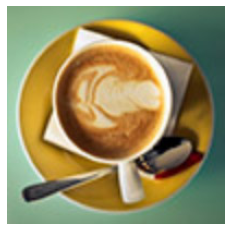

In [13]:
plt.imshow(img)
plt.axis('off')
plt.show()

### Reduced color image

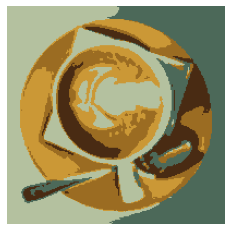

In [14]:
plt.imshow(new_img)
plt.axis('off')
plt.show()

In [23]:
from PIL import Image
import pandas as pd

colourImg = Image.open("../data/coffee.jpg")
colourPixels = colourImg.convert("RGB")
colourArray = np.array(colourPixels.getdata()).reshape(colourImg.size + (3,))
indicesArray = np.moveaxis(np.indices(colourImg.size), 0, 2)
allArray = np.dstack((indicesArray, colourArray)).reshape((-1, 5))


data = pd.DataFrame(allArray, columns=["y", "x", "red","green","blue"])

[(0, 0, 130, 168, 129), (0, 1, 130, 168, 129), (0, 2, 130, 168, 129), (0, 3, 130, 168, 129), (0, 4, 130, 168, 129), (0, 5, 130, 168, 129), (0, 6, 130, 168, 129), (0, 7, 130, 168, 129), (0, 8, 130, 168, 129), (0, 9, 130, 168, 129), (0, 10, 131, 169, 130), (0, 11, 131, 169, 130), (0, 12, 131, 169, 130), (0, 13, 131, 169, 130), (0, 14, 131, 169, 130), (0, 15, 131, 169, 130), (0, 16, 131, 169, 130), (0, 17, 131, 169, 130), (0, 18, 131, 169, 130), (0, 19, 131, 169, 130), (0, 20, 132, 170, 131), (0, 21, 132, 170, 131), (0, 22, 132, 170, 131), (0, 23, 132, 170, 131), (0, 24, 132, 170, 131), (0, 25, 132, 170, 131), (0, 26, 132, 170, 131), (0, 27, 132, 170, 131), (0, 28, 133, 171, 132), (0, 29, 133, 171, 132), (0, 30, 133, 171, 132), (0, 31, 133, 171, 132), (0, 32, 134, 172, 133), (0, 33, 134, 172, 133), (0, 34, 134, 172, 133), (0, 35, 134, 172, 133), (0, 36, 134, 172, 133), (0, 37, 134, 172, 133), (0, 38, 134, 172, 133), (0, 39, 134, 172, 133), (0, 40, 135, 173, 134), (0, 41, 135, 173, 134), (

ValueError: too many values to unpack (expected 2)

<Figure size 1080x648 with 0 Axes>

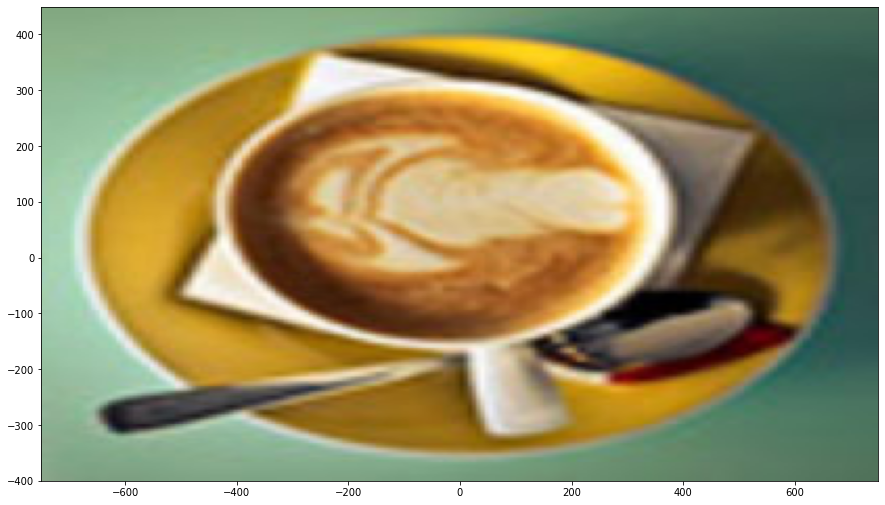

In [24]:
#Conversion of dataframe to array of tuples:
plotdata = list(data.to_records(index=False)) #data is the dataframe of coordinates
print(plotdata)

img = plt.imread("../data/coffee.jpg")
fig = plt.figure(figsize = (15, 9))
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
ax.imshow(img, extent=[-750, 750, -400, 450], zorder=1)
x, y = zip(*plotdata)
plt.scatter(x, y, data=data, color='red', zorder=2)

***

# Bottom-Up Hierarchical Clustering

In [ ]:
from typing import NamedTuple, Union

In [ ]:
class Leaf(NamedTuple):
    value: Vector
        
leaf1 = Leaf([10, 20])
leaf2 = Leaf([30, -15])

class Merged(NamedTuple):
    children: tuple
    order: int

merged = Merged((leaf1, leaf2), order=1)

Cluster = Union[Leaf, Merged]

In [ ]:
def get_values(cluster: Cluster) -> List[Vector]:
    if isinstance(cluster, Leaf):
        return [cluster.value]
    else:
        return [value
                for child in cluster.children
                for value in get_values(child)]

assert get_values(merged) == [[10, 20], [30, -15]]

In [ ]:
from typing import Callable

def cluster_distance(cluster1: Cluster,
                     cluster2: Cluster,
                     distance_agg: Callable = min) -> float:
    """
    compute all the pairwise distances between cluster1 and cluster2
    and apply the aggregation function _distance_agg_ to the resulting list
    """
    return distance_agg([distance(v1, v2)
                         for v1 in get_values(cluster1)
                         for v2 in get_values(cluster2)])

In [ ]:
def get_merge_order(cluster: Cluster) -> float:
    if isinstance(cluster, Leaf):
        return float('inf')  # was never merged
    else:
        return cluster.order

In [ ]:
from typing import Tuple

def get_children(cluster: Cluster):
    if isinstance(cluster, Leaf):
        raise TypeError("Leaf has no children")
    else:
        return cluster.children


In [ ]:
def bottom_up_cluster(inputs: List[Vector],
                      distance_agg: Callable = min) -> Cluster:
    # Start with all leaves
    clusters: List[Cluster] = [Leaf(input) for input in inputs]

    def pair_distance(pair: Tuple[Cluster, Cluster]) -> float:
        return cluster_distance(pair[0], pair[1], distance_agg)

    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min(((cluster1, cluster2)
                      for i, cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]),
                      key=pair_distance)

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = Merged((c1, c2), order=len(clusters))

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

In [ ]:
def generate_clusters(base_cluster: Cluster,
                      num_clusters: int) -> List[Cluster]:
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]

        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters

In [ ]:
def main():
    
    
    inputs: List[List[float]] = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]
    
    random.seed(12)                   # so you get the same results as me
    clusterer = KMeans(k=3)
    clusterer.train(inputs)
    means = sorted(clusterer.means)   # sort for the unit test
    
    assert len(means) == 3
    
    # Check that the means are close to what we expect.
    assert squared_distance(means[0], [-44, 5]) < 1
    assert squared_distance(means[1], [-16, -10]) < 1
    assert squared_distance(means[2], [18, 20]) < 1
    
    random.seed(0)
    clusterer = KMeans(k=2)
    clusterer.train(inputs)
    means = sorted(clusterer.means)
    
    assert len(means) == 2
    assert squared_distance(means[0], [-26, -5]) < 1
    assert squared_distance(means[1], [18, 20]) < 1
    
    from matplotlib import pyplot as plt
    
    def squared_clustering_errors(inputs: List[Vector], k: int) -> float:
        """finds the total squared error from k-means clustering the inputs"""
        clusterer = KMeans(k)
        clusterer.train(inputs)
        means = clusterer.means
        assignments = [clusterer.classify(input) for input in inputs]
    
        return sum(squared_distance(input, means[cluster])
                   for input, cluster in zip(inputs, assignments))
    
    # now plot from 1 up to len(inputs) clusters
    
    ks = range(1, len(inputs) + 1)
    errors = [squared_clustering_errors(inputs, k) for k in ks]
    
    plt.plot(ks, errors)
    plt.xticks(ks)
    plt.xlabel("k")
    plt.ylabel("total squared error")
    plt.title("Total Error vs. # of Clusters")
    # plt.show()
    
    
    
    plt.savefig('im/total_error_vs_num_clusters')
    plt.gca().clear()
    
    image_path = r"girl_with_book.jpg"    # wherever your image is
    import matplotlib.image as mpimg
    img = mpimg.imread(image_path) / 256  # rescale to between 0 and 1
    
    # .tolist() converts a numpy array to a Python list
    pixels = [pixel.tolist() for row in img for pixel in row]
    
    clusterer = KMeans(5)
    clusterer.train(pixels)   # this might take a while
    
    def recolor(pixel: Vector) -> Vector:
        cluster = clusterer.classify(pixel)        # index of the closest cluster
        return clusterer.means[cluster]            # mean of the closest cluster
    
    new_img = [[recolor(pixel) for pixel in row]   # recolor this row of pixels
               for row in img]                     # for each row in the image
    
    
    plt.close()
    
    plt.imshow(new_img)
    plt.axis('off')
    # plt.show()
    
    
    
    plt.savefig('im/recolored_girl_with_book.jpg')
    plt.gca().clear()
    
    base_cluster = bottom_up_cluster(inputs)
    
    three_clusters = [get_values(cluster)
                      for cluster in generate_clusters(base_cluster, 3)]
    
    
    
    # sort smallest to largest
    tc = sorted(three_clusters, key=len)
    assert len(tc) == 3
    assert [len(c) for c in tc] == [2, 4, 14]
    assert sorted(tc[0]) == [[11, 15], [13, 13]]
    
    
    plt.close()
    
    for i, cluster, marker, color in zip([1, 2, 3],
                                         three_clusters,
                                         ['D','o','*'],
                                         ['r','g','b']):
        xs, ys = zip(*cluster)  # magic unzipping trick
        plt.scatter(xs, ys, color=color, marker=marker)
    
        # put a number at the mean of the cluster
        x, y = vector_mean(cluster)
        plt.plot(x, y, marker='$' + str(i) + '$', color='black')
    
    plt.title("User Locations -- 3 Bottom-Up Clusters, Min")
    plt.xlabel("blocks east of city center")
    plt.ylabel("blocks north of city center")
    # plt.show()
    
    
    
    plt.savefig('im/bottom_up_clusters_min.png')
    plt.gca().clear()
    plt.close()
    
    
    
    base_cluster_max = bottom_up_cluster(inputs, max)
    three_clusters_max = [get_values(cluster)
                          for cluster in generate_clusters(base_cluster_max, 3)]
    
    for i, cluster, marker, color in zip([1, 2, 3],
                                         three_clusters_max,
                                         ['D','o','*'],
                                         ['r','g','b']):
        xs, ys = zip(*cluster)  # magic unzipping trick
        plt.scatter(xs, ys, color=color, marker=marker)
    
        # put a number at the mean of the cluster
        x, y = vector_mean(cluster)
        plt.plot(x, y, marker='$' + str(i) + '$', color='black')
    
    plt.title("User Locations -- 3 Bottom-Up Clusters, Max")
    plt.xlabel("blocks east of city center")
    plt.ylabel("blocks north of city center")
    plt.savefig('im/bottom_up_clusters_max.png')
    plt.gca().clear()
    
if __name__ == "__main__": main()